# Making a `filter_info` file

This example will guide you through how to make a `filter\_info.csv` file for your test data.
Filtering/data reduction is done through fixed-point polyfitting.
There are two objectives of this procedure: 1) to reduce the noise in your tests while maintaining the peaks of the true stress-strain curves; and 2) to reduce the number of data points so that analysis time using `RESSPyLab` is reduced.

`rlmtp` is designed to make repeatible studies.
The idea behind the filter info file is to provide a clear path from the unreduced data to the final data that will be operated on by the user.
Providing this path allows for any user (including yourself!) to easily repeat your results at any time in the future, enhancing the openness of your study.

`filter_info.csv` files guide `rlmtp` in selecting the final data set that you would like to keep for each test.
Typically this file will contain the peaks of the stress-strain curve, along with other potential points of interest, such as the upper yield point in mild steels.
Between these selected points you specify how often to sample the data, and a point is added in-between the sample points using interpolation.
All the points that are not sampled are removed from the data, therefore the frequency of sampling determines the size of the final output.

## `filter_info.csv` file format

First, the filter info file should be located in the specimen directory for the test of interest (for info on the specimen directory see <../protocols/readme.md>).
Each odd-numbered line in this file provides two pieces of information: 1) the window length to use, 2) the order of polynomial to fit within this window.
Each even-numbered line in this file provides the indices of the points that must be included in the data and cannot be reduced out.
Example anchor points are the peaks of the stress-strain data.
The anchor points on any line correspond to the window length and polyfit order of the line above it.

I will note a few things, then illustrate how to specify a `filter_info.csv` file with an example.
- The final data will start with the first anchor point and end with the last anchor point.
- A polyfit order of "0" can be used, specifying poly_order=0 removes all the data between anchor points without fitting. This is useful when there are certain regions in your data that you want to ignore completely and cannot just be reduced.
- The default polyfit order is 1 (linear interpolation), leaving the order empty uses linear interpolation.

## Basic example

First we generate some data then fill out the filter info file.
The `mpldatacursor` package can be useful to pick the peaks of some data, or importing the data into Matlab is useful.

<IPython.core.display.Javascript object>


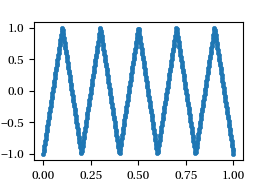

In [3]:
%matplotlib nbagg

from scipy import signal
import numpy as np
import matplotlib
# matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpldatacursor import datacursor


fig, ax = plt.subplots()
t = np.linspace(0, 1, 500)
data = signal.sawtooth(2 * np.pi * 5 * t, 0.5)
lines = ax.plot(t, data, 'o')

labels = [str(i) for i in range(len(data))]
datacursor(lines, point_labels=labels)
plt.show()

Now we can fill out the `filter_info.csv` file as follows:


====

```
5,
24, 50, 100, 150, 200, 249, 299, 349, 399, 449, 499

```
====


This would specify a window length of 5, a polyfit order of 1, and the chosen anchor points.
Here I chose the data to start at point 24, approximately where the data crosses the x-axis for the first time.

### A word of caution on higher-order interpolation

Higher order interpolation is not recommended because it can lead to poor results depending on the chosen anchor points and window lengths. For example, if you have anchor points at 0 and 10, and a window length of 9, then you will have sample points at [0, 9] and [9, 10]. The second pair will lead to an overfitted problem where you have no guarentee on the behavior between the two points.

## Extended example

In this example we will make full use of all the features of the filter info file and show the results using `rlmtp`.

<IPython.core.display.Javascript object>


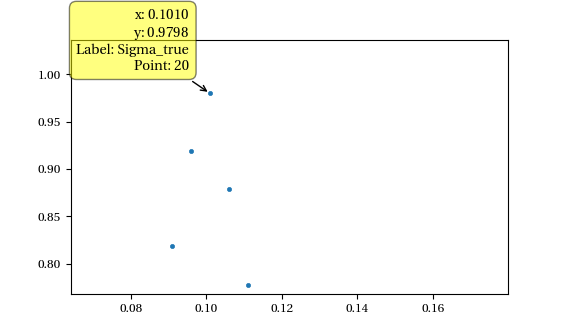

In [12]:
import pandas as pd
import rlmtp
# Set-up the data the way rlmtp expects it
# Here we have a higher data frequency from 1--2
t = np.append(np.linspace(0, 0.5, 100), 0.5 + np.linspace(0, 0.5, 200))
x = t.copy()
y = signal.sawtooth(2 * np.pi * 5 * t, 0.5)
data = pd.DataFrame()
data['e_true'] = x
data['Sigma_true'] = y
data['C_1_Temps[s]'] = t

fig, ax = plt.subplots()
lines = ax.plot(data['e_true'], data['Sigma_true'], 'o')
labels = [str(i) for i in range(len(data))]
datacursor(lines, point_labels=labels)
plt.show()

Now we will construct the `filter_info.csv` file as follows:

====
```
100, 0
0, 20
5,
50, 100
10,
140, 180, 219, 259, 299

```
====

Let's go through step-by-step:
1. The first line specifies a window length of 100 and a polyfit order of 0
2. The second line specifies anchor points at the 0 and 24 indices. Everything else in-between will be removed because of poly_order=0 and the window length is 100. data[20] is the first peak.
3. The third line specifies a window length of 5 and a polyfit order of 1.
4. The fourth line specifies anchor points at the 50 and 100 indices. Linear interpolation will be made starting at point 50 sampling every 5th point and adding a point in-between.
5. The fifth line specifies a window length of 10 and a polyfit order of 1.
6. The sixth line specifies the rest of our anchor points.

Up to here is all you would need to do, but we will define a few extra things and make use of the functions directly to show you the results.

In [17]:
filter_info = {'anchors': [[0, 20], [50, 100], [140, 180, 219, 259, 299]], 'window': [100, 5, 10], 'poly_order': [0, 1, 1]}
filtered_data = rlmtp.filtering.clean_data(data, filter_info)

Data reduced from 300 to 74 data points.


<IPython.core.display.Javascript object>


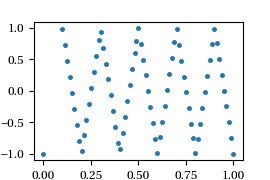

In [18]:
# Now plot the filtered/reduced data
fig, ax = plt.subplots()
lines = ax.plot(filtered_data['e_true'], filtered_data['Sigma_true'], 'o')
plt.show()

Notice how there is a relatively even distribution of data? Using different window lengths is very useful when there are changes in the frequency of data points.